In [23]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [24]:
df = pd.read_csv('personality_dataset.csv')
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


In [25]:
df.columns

Index(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


C:\Users\Admin\AppData\Local\Temp\ipykernel_13516\761011391.py:15: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


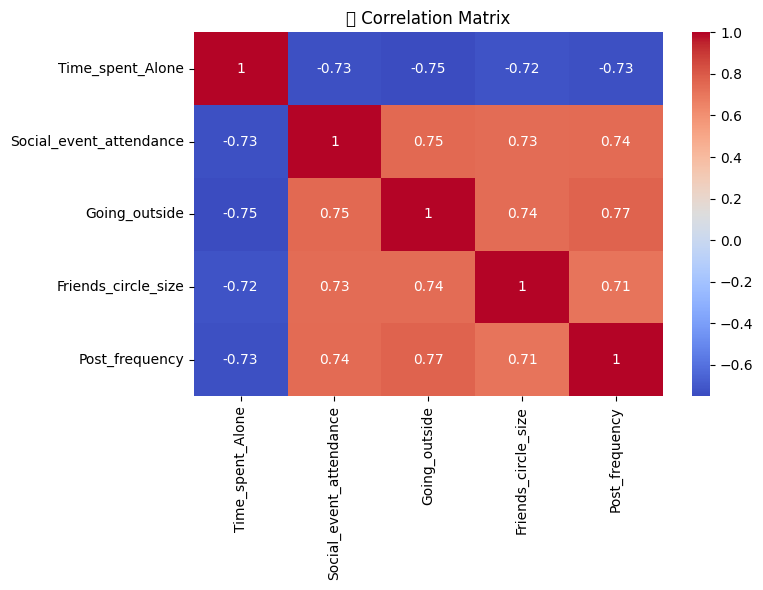

In [27]:
# pairplot และ heatmap สำหรับ numerical features
eda_df = df
numerical_cols = eda_df.select_dtypes(include="number").columns

# ตรวจสอบว่ามีข้อมูลพอสำหรับ pairplot
if eda_df[numerical_cols].dropna().shape[0] > 200:
    sample_for_plot = eda_df[numerical_cols].dropna().sample(200, random_state=42)  # ลดขนาด
else:
    sample_for_plot = eda_df[numerical_cols].dropna()

# Heatmap correlation
plt.figure(figsize=(8, 6))
sns.heatmap(eda_df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("🔗 Correlation Matrix")
plt.tight_layout()
plt.show()



C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


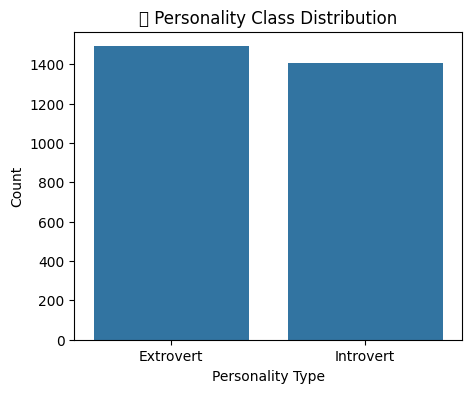

In [28]:
# Countplot target
plt.figure(figsize=(5, 4))
sns.countplot(data=eda_df, x="Personality")
plt.title("🔍 Personality Class Distribution")
plt.xlabel("Personality Type")
plt.ylabel("Count")
plt.show()

In [29]:
# Impute missing numerical values
num_cols = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy="mean")
df[num_cols] = imputer.fit_transform(df[num_cols])

# Encode categorical variables
cat_cols = df.select_dtypes(include="object").columns.drop("Personality")
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Encode target
target_le = LabelEncoder()
df["Personality"] = target_le.fit_transform(df["Personality"])

# Split
X = df.drop(columns=["Personality"])
y = df["Personality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [30]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_le.classes_))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9189655172413793

Classification Report:
              precision    recall  f1-score   support

   Extrovert       0.93      0.91      0.92       302
   Introvert       0.91      0.93      0.92       278

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580


Confusion Matrix:
[[275  27]
 [ 20 258]]


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [11:00:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


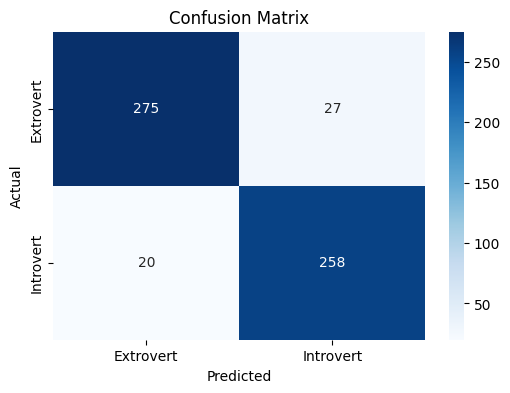

In [31]:

# Confusion matrix heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_le.classes_, yticklabels=target_le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


<Figure size 1000x600 with 0 Axes>

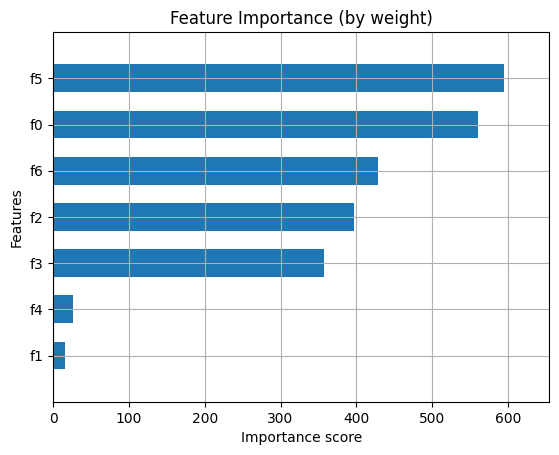

In [32]:

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(model, height=0.6, importance_type='weight', show_values=False)
plt.title("Feature Importance (by weight)")
plt.show()


    - Time_spent_Alone: Hours spent alone daily (0–11).
    - Stage_fear: Presence of stage fright (Yes/No).
    - Social_event_attendance: Frequency of social events (0–10).
    - Going_outside: Frequency of going outside (0–7).
    - Drained_after_socializing: Feeling drained after socializing (Yes/No).
    - Friends_circle_size: Number of close friends (0–15).
    - Post_frequency: Social media post frequency (0–10).


In [33]:
Time_spent_Alone=int(input("Enter the time spent alone (0-11): "))
Stage_fear=input("Do you have stage fear? (Yes/No): ")
Social_event_attendance=int(input("Enter the number of social events attended in the last month (0-10): "))
Going_outsite=int(input("Enter the number of times you went outside in the last week (0-7): "))
Drained_after_socializing=input("Do you feel drained after socializing? (Yes/No): ")
Friends_circle_size=int(input("Enter the number of close friends (0-15): "))
Post_frequency=int(input("Enter your social media post frequency (0-10): "))

ValueError: invalid literal for int() with base 10: ''

In [ ]:
# 🔍 ทำนายบุคลิกภาพจากข้อมูลแบบสอบถาม

# ตัวอย่าง input (แก้ค่าตามที่ได้จากแบบสอบถาม)
sample_input = {
    'Time_spent_Alone':Time_spent_Alone,
    'Stage_fear':  Stage_fear,
    'Social_event_attendance': Social_event_attendance,
    'Going_outside': Going_outsite,
    'Drained_after_socializing': Drained_after_socializing,
    'Friends_circle_size': Friends_circle_size,
    'Post_frequency': Post_frequency
}

# แปลง input เป็น DataFrame
sample_df = pd.DataFrame([sample_input])

# แปลงค่าข้อความด้วย encoder เดิม
for col in ['Stage_fear', 'Drained_after_socializing']:
    le = label_encoders[col]
    sample_df[col] = le.transform(sample_df[col])

# เติมคอลัมน์ที่เรียงเหมือนตอนเทรน
sample_df = sample_df[X.columns]

# scale ข้อมูล
sample_scaled = scaler.transform(sample_df)

# ทำนาย
predicted_class = model.predict(sample_scaled)[0]
predicted_label = target_le.inverse_transform([predicted_class])[0]

print("🔮 ผลการทำนาย: บุคลิกภาพของคุณคือ -->", predicted_label)


🔮 ผลการทำนาย: บุคลิกภาพของคุณคือ --> Introvert
